In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

import pickle

### Loading Data and  Preprocessing Pipeline

In [3]:
def read_dataframe(filename):
    """
    Pipeline for loading dataset and preprocessing
    """
    df = pd.read_parquet(filename)
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda dur: dur.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
## train and validation set
df_train = read_dataframe('./dataset/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./dataset/green_tripdata_2021-02.parquet')

In [5]:
len(df_train), len(df_val)

(73908, 61921)

In [6]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [7]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.0,...,0.5,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.5,...,0.5,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.5,...,0.5,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.0,...,0.5,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.5,...,0.5,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667


#### Explore Training Set

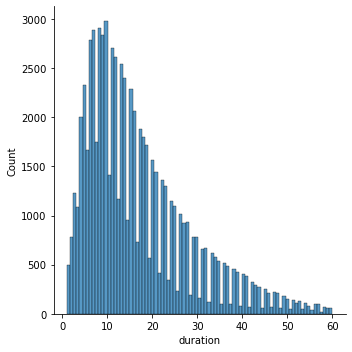

In [8]:
sns.displot(df_train.duration)
plt.show()

In [9]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [10]:
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

### Training Pipeline

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
# categorical = ['PULocationID','DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values 
y_val = df_val[target].values 

#### Prediction on Training Set

In [14]:
## model building (Linear Regression)

lr = LinearRegression()
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_train)   ### prediction inference

## model evaluation
mean_squared_error(y_train, y_pred, squared=False)  ### root mean square

4.640806756703752

#### Prediction on Validation Set

In [15]:
## model building (Linear Regression)

lr = LinearRegression()
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_val)   ### prediction inference

## model evaluation
mean_squared_error(y_val, y_pred, squared=False)  ### root mean square

7.479556169484162

### Save Linear Regression models

In [225]:
with open('./models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)

#### Additional: Try Out Other Models

In [220]:
## model building (Lasso with alpha 0.001)

lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_val)   ### prediction inference

## model evaluation
mean_squared_error(y_val, y_pred, squared=False)  ### root mean square

9.233436225720547

In [221]:
## model building (Ridge with alpha 0.001)

lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_val)   ### prediction inference

## model evaluation
mean_squared_error(y_val, y_pred, squared=False)  ### root mean square

11.342565604820129